# Import libraries

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Transform Object Definition

For train data set we will use rotation and horizontol flip to increase data content to cover wider different figures

In [3]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(),
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])

For test data set we will only use resize,centercrop, to tensor and normalization transform

In [4]:
test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Importing image data using dataloader

In [5]:
root = 'CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
#we can just cast train root completely in imagefolder() paranthesis
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes # specify classes

In [6]:
#To display class names we can write 
class_names

['CAT', 'DOG']

In [7]:
len(train_data)

18743

In [8]:
len(test_data)

6251

# Displaying first batch of the image

In [9]:
for i,(images,labels) in enumerate(train_loader):
    break

In [20]:
images.shape

torch.Size([10, 3, 224, 224])

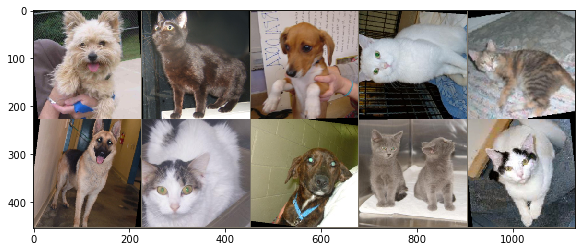

In [77]:
im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

# Convolutional Neural Network

In [13]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)
                 

In [14]:
torch.manual_seed(101)

In [15]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

Checking model parameters

In [18]:
for param in model.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
168
2


# Training

In [21]:
import time
start_time = time.time()

epochs = 3

#Limits on numbers of batches if you want train faster(Not mandatory)
max_trn_batch = 800 # batch 10 image --> 8000 images total
max_tst_batch = 300 # batch 10 image --> 3000 images total


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
        #optinal limit number of batches
        if b == max_trn_batch:
            break
        b = b + 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr = trn_corr + batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print('Epoch:  {} Loss:  {} Accuracy:  {}'.format(i,loss,trn_corr.item()*100/(10*b)))
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    #test set
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            #Optional
            if b==max_tst_batch:
                break
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
    
total_time = time.time() - start_time
print(f'Total Time: {total_time/60}) minutes')

Epoch:  0 Loss:  0.7279319167137146 Accuracy:  57.35
Epoch:  0 Loss:  0.7570854425430298 Accuracy:  60.05
Epoch:  0 Loss:  0.46692854166030884 Accuracy:  61.666666666666664
Epoch:  0 Loss:  0.40075206756591797 Accuracy:  63.5
Epoch:  1 Loss:  0.4249531328678131 Accuracy:  68.3
Epoch:  1 Loss:  0.4924251437187195 Accuracy:  70.05
Epoch:  1 Loss:  0.6591123342514038 Accuracy:  70.18333333333334
Epoch:  1 Loss:  0.393338143825531 Accuracy:  70.525
Epoch:  2 Loss:  0.2987462878227234 Accuracy:  72.95
Epoch:  2 Loss:  0.3645065426826477 Accuracy:  72.95
Epoch:  2 Loss:  0.32618826627731323 Accuracy:  73.25
Epoch:  2 Loss:  0.2933819890022278 Accuracy:  74.0625
Total Time: 16.758749115467072) minutes


# Saving the trained model

In [23]:
torch.save(model.state_dict(),'CatandDog.pt')

# Result visualization

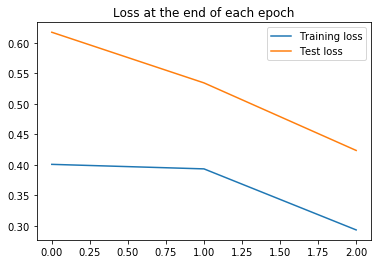

In [24]:
plt.plot(train_losses,label='Training loss')
plt.plot(test_losses,label='Test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

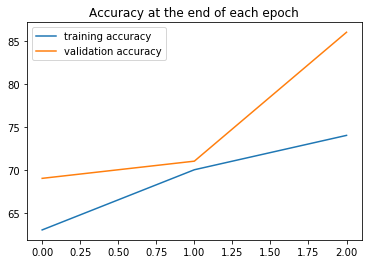

In [31]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

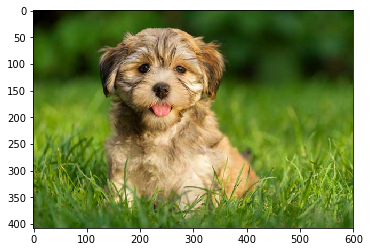

torch.Size([3, 224, 224])

In [64]:
newim = mpimg.imread("test.jpg")
plt.imshow(newim)
plt.show()
newim.shape
newimpil = Image.fromarray(newim)
newim2 = test_transform(newimpil)
newim2.shape

In [72]:
model.eval()

with torch.no_grad():
    new_data = model(newim2.view(1,3,224,224))
    predict = torch.max(new_data.data,1)[1]

In [73]:
predict # 1 is dog and 0 is cat

tensor([1])

<BarContainer object of 2 artists>

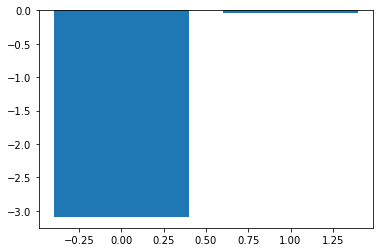

In [107]:
plt.bar(range(2), new_data[0])